In [1]:
import bilby
import matplotlib.pyplot as plt 
from bilby.core.prior import ConditionalLogUniform, LogUniform, TruncatedGaussian,LogNormal,ConditionalUniform
from bilby.core.prior import PriorDict, Uniform, Constraint,ConditionalInterped,ConditionalPriorDict,Cosine,Sine
import bilby.gw.prior
import numpy as np 
from BNSPriorDict_ChirpMassLambda import BNSPriorDict_chirpmass_lambda_tilde, convert_to_lal_binary_neutron_star_parameters_mchirp

In [2]:

# Specify the output directory and the name of the simulation.
outdir = "outdir_nsbh"
# Now we try to sample and see what the error is in generating the probabilies
label = "nsbh_example"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

In [45]:
# We are going to inject a GW190425-like system (masses) that is a NSBH merger

#We first establish a dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two neutron stars (mass_1, mass_2),
# aligned spins of both NSs (chi_1, chi_2), etc.
mass_1_source = 2.4
mass_2_source = 1.15 
lambda_1 = 0
lambda_2 = 1346
injection_parameters = dict(
    mass_1_source=mass_1_source,
    mass_2_source=mass_2_source,
    chi_1=0.02,
    chi_2=0.02,
    luminosity_distance=50.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    
)

In [46]:
def lambda_1_lambda_2_to_lambda_tilde_NSBH(lambda_1, lambda_2, mass_1, mass_2): 
    lambda_tilde = 16./13. * ((12*mass_1 + mass_2)*lambda_2*mass_2**4)/(mass_1+ mass_2)**5.
    return lambda_tilde

In [47]:
# Calculate lambda_tilde 
lambda_tilde = lambda_1_lambda_2_to_lambda_tilde_NSBH(lambda_1, lambda_2, mass_1_source, mass_2_source)
#lambda_tilde = bilby.gw.conversion.lambda_1_lambda_2_to_lambda_tilde(lambda_1, lambda_2, mass_1_source, mass_2_source)
print(lambda_tilde)
chirp_mass_source = bilby.gw.conversion.component_masses_to_chirp_mass(mass_1_source, mass_2_source)
print(chirp_mass_source)

153.9104518214027
1.427249102656435


In [50]:
# We setup the prior dict using the interpolated prior from the file
priors_gw = BNSPriorDict_chirpmass_lambda_tilde(MCL_filename='./MCL_NSBH_new.dat')
# Delta lambda tilde is defined with a uniform prior
priors_gw['delta_lambda_tilde'] = Uniform(name='delta_lambda_tilde', minimum=-5000, maximum=5000, boundary=None)
# Define the other priors for inference 
priors_gw['luminosity_distance'] = 250.0 #bilby.gw.prior.UniformSourceFrame(name='luminosity_distance', minimum=1e2, maximum=5e3)
# Fix everything to injected values other than Mchirp and lambda_tilde
priors_gw['dec'] = - 1.2108 #Cosine(name='dec')
priors_gw['ra'] = 1.375 #Uniform(name='ra', minimum=0, maximum=2 * np.pi, boundary='periodic')
priors_gw['theta_jn'] = 0.4 #Sine(name='theta_jn')
priors_gw['psi'] =  2.659 #Uniform(name='psi', minimum=0, maximum=np.pi, boundary='periodic')
priors_gw['phase'] = 1.3 #Uniform(name='phase', minimum=0, maximum=2 * np.pi, boundary='periodic')
priors_gw['chi_1'] = 0.02 #bilby.gw.prior.AlignedSpin(name='chi_1', a_prior=Uniform(minimum=0, maximum=0.99))
priors_gw['chi_2'] = 0.02 #bilby.gw.prior.AlignedSpin(name='chi_2', a_prior=Uniform(minimum=0, maximum=0.99))
priors_gw['mass_ratio'] =1.3/1.5 #bilby.gw.prior.UniformInComponentsMassRatio(name='mass_ratio', minimum=0.125, maximum=1)
priors_gw['mass_1'] = Constraint(name='mass_1', minimum=0.5, maximum=5)
priors_gw['mass_2'] = Constraint(name='mass_2', minimum=0.5, maximum=5)

15:22 bilby INFO    : No prior given, using default BNS priors in /Users/smag0001/opt/anaconda3/lib/python3.10/site-packages/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.
15:22 bilby INFO    : Interpolating chirp_mass_source and lambda_tilde prior from file.


Text(0, 0.5, 'Chirp Mass (source frame)')

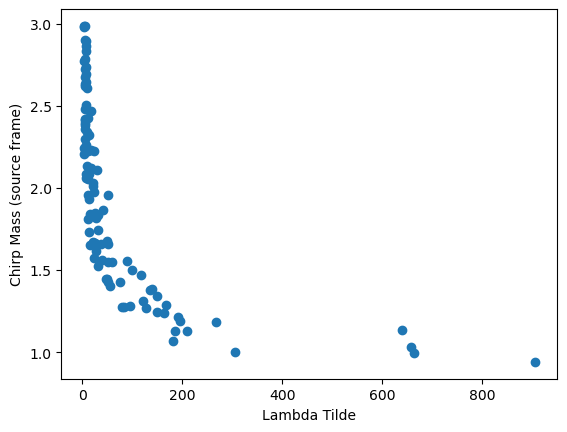

In [51]:
# Check that the prior is loaded by sampling from it
samples = priors_gw.sample(100)
# Plot the prior samples
plt.scatter(samples['lambda_tilde'], samples['chirp_mass_source'])
plt.xlabel('Lambda Tilde')
plt.ylabel('Chirp Mass (source frame)')

In [52]:


# Fix most of the priors to their injected values
for key in [
    "psi",
    "geocent_time",
    "ra",
    "dec",
    "chi_1",
    "chi_2",
    "theta_jn",
    #"luminosity_distance",
    "phase",
]:
    priors_gw[key] = injection_parameters[key]
# We explicitly set the system as a NSBH since we need to use a different conversion function to generate lambda_1 and lambda_2 
# from lambda_tilde and the masses
#priors_gw['system_type'] = 'NSBH'
#priors_gw['system_type'] = bilby.core.prior.DeltaFunction(peak='NSBH')
priors_gw['lambda_1'] = 0.0
#print(priors_gw)

In [53]:
# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 32
minimum_frequency=400
sampling_frequency = 2048
start_time = injection_parameters["geocent_time"] + 2 - duration

# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2_NRTidal",
    reference_frequency=50.0,
    minimum_frequency=minimum_frequency,
)

In [54]:
# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    #parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    #parameter_conversion=BNSPriorDict_chirpmass_lambda_tilde.default_conversion_function,
    parameter_conversion=convert_to_lal_binary_neutron_star_parameters_mchirp,
    waveform_arguments=waveform_arguments,
)

15:22 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: BNSPriorDict_ChirpMassLambda.convert_to_lal_binary_neutron_star_parameters_mchirp


In [25]:
# Set up interferometers.  In this case we'll use three interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1), and Virgo (V1)).
# These default to their design sensitivity and start at 40 Hz.
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
for interferometer in interferometers:
    interferometer.minimum_frequency = 40
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)

15:08 bilby INFO    : Injected signal in H1:
15:08 bilby INFO    :   optimal SNR = 1.70
15:08 bilby INFO    :   matched filter SNR = 0.96+0.39j
15:08 bilby INFO    :   mass_1_source = 2.4
15:08 bilby INFO    :   mass_2_source = 1.15
15:08 bilby INFO    :   chi_1 = 0.02
15:08 bilby INFO    :   chi_2 = 0.02
15:08 bilby INFO    :   luminosity_distance = 250.0
15:08 bilby INFO    :   theta_jn = 0.4
15:08 bilby INFO    :   psi = 2.659
15:08 bilby INFO    :   phase = 1.3
15:08 bilby INFO    :   geocent_time = 1126259642.413
15:08 bilby INFO    :   ra = 1.375
15:08 bilby INFO    :   dec = -1.2108
15:08 bilby INFO    :   lambda_1 = 0
15:08 bilby INFO    :   lambda_2 = 1346
15:08 bilby INFO    : Injected signal in L1:
15:08 bilby INFO    :   optimal SNR = 1.38
15:08 bilby INFO    :   matched filter SNR = 1.35-0.49j
15:08 bilby INFO    :   mass_1_source = 2.4
15:08 bilby INFO    :   mass_2_source = 1.15
15:08 bilby INFO    :   chi_1 = 0.02
15:08 bilby INFO    :   chi_2 = 0.02
15:08 bilby INFO   

[{'plus': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -9.05485035e-26+2.82680873e-26j, -9.05493881e-26+2.82521502e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         2.81727869e-26+9.02432367e-26j, 2.81569036e-26+9.02441183e-26j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -9.05485035e-26+2.82680873e-26j, -9.05493881e-26+2.82521502e-26j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         2.81727869e-26+9.02432367e-26j, 2.81569036e-26+9.02441183e-26j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': ar

In [55]:
# Initialise the likelihood by passing in the interferometer data (IFOs)
# and the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=interferometers,
    waveform_generator=waveform_generator,
)

In [56]:
# WHY DOES THIS WORK!!!!!!
priors_gw = dict(priors_gw)
print(priors_gw)

#nsteps = 2000
#burnin = nsteps // 3

# Run sampler.  In this case we're going to use the `nestle` sampler
# This will be very slow depending on your chosen signal 
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors_gw,
    sampler="nestle",
    nlive=400,
    #injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    npool=1,
)

15:22 bilby INFO    : Running for label 'nsbh_example', output will be saved to 'outdir_nsbh'
15:22 bilby INFO    : Using lal version 7.3.1
15:22 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed
15:22 bilby INFO    : Using lalsimulation version 5.2.1
15:22 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.19;Id: 84d780c102cf51ea1fdf7a1cbf0a626a5eca0d0a;;Builder: Duncan Macleod <duncan.macleod@ligo.org>;Repository status: CLEAN: All modifications committed


{'mass_1': Constraint(minimum=0.5, maximum=5, name='mass_1', latex_label='$m_1$', unit=None), 'mass_2': Constraint(minimum=0.5, maximum=5, name='mass_2', latex_label='$m_2$', unit=None), 'mass_ratio': DeltaFunction(peak=0.8666666666666667, name=None, latex_label=None, unit=None), 'luminosity_distance': DeltaFunction(peak=250.0, name=None, latex_label=None, unit=None), 'dec': -1.2108, 'ra': 1.375, 'theta_jn': 0.4, 'psi': 2.659, 'phase': 1.3, 'chirp_mass_source': Interped(xx=array([0.805528  , 0.81658327, 0.82763855, 0.83869382, 0.84974909,
       0.86080436, 0.87185964, 0.88291491, 0.89397018, 0.90502545,
       0.91608073, 0.927136  , 0.93819127, 0.94924655, 0.96030182,
       0.97135709, 0.98241236, 0.99346764, 1.00452291, 1.01557818,
       1.02663345, 1.03768873, 1.048744  , 1.05979927, 1.07085455,
       1.08190982, 1.09296509, 1.10402036, 1.11507564, 1.12613091,
       1.13718618, 1.14824145, 1.15929673, 1.170352  , 1.18140727,
       1.19246255, 1.20351782, 1.21457309, 1.22562836

15:22 bilby INFO    : Analysis priors:
15:22 bilby INFO    : chirp_mass_source=Interped(xx=array([0.805528  , 0.81658327, 0.82763855, 0.83869382, 0.84974909,
       0.86080436, 0.87185964, 0.88291491, 0.89397018, 0.90502545,
       0.91608073, 0.927136  , 0.93819127, 0.94924655, 0.96030182,
       0.97135709, 0.98241236, 0.99346764, 1.00452291, 1.01557818,
       1.02663345, 1.03768873, 1.048744  , 1.05979927, 1.07085455,
       1.08190982, 1.09296509, 1.10402036, 1.11507564, 1.12613091,
       1.13718618, 1.14824145, 1.15929673, 1.170352  , 1.18140727,
       1.19246255, 1.20351782, 1.21457309, 1.22562836, 1.23668364,
       1.24773891, 1.25879418, 1.26984945, 1.28090473, 1.29196   ,
       1.30301527, 1.31407055, 1.32512582, 1.33618109, 1.34723636,
       1.35829164, 1.36934691, 1.38040218, 1.39145745, 1.40251273,
       1.413568  , 1.42462327, 1.43567855, 1.44673382, 1.45778909,
       1.46884436, 1.47989964, 1.49095491, 1.50201018, 1.51306545,
       1.52412073, 1.535176  , 1.54623

it=  1916 logz=-2.1580595


15:26 bilby INFO    : Sampling time: 0:03:09.699457
15:26 bilby ERROR   : 

Saving the data has failed with the following message:
Object of type method is not JSON serializable
Data has been dumped to outdir_nsbh/nsbh_example_result.pkl.


15:26 bilby ERROR   : 

Saving the data has failed with the following message:
Object of type method is not JSON serializable
Data has been dumped to outdir_nsbh/nsbh_example_result.pkl.


15:26 bilby INFO    : Summary of results:
nsamples: 2317
ln_noise_evidence: -95096.162
ln_evidence: -95098.002 +/-  0.067
ln_bayes_factor: -1.840 +/-  0.067



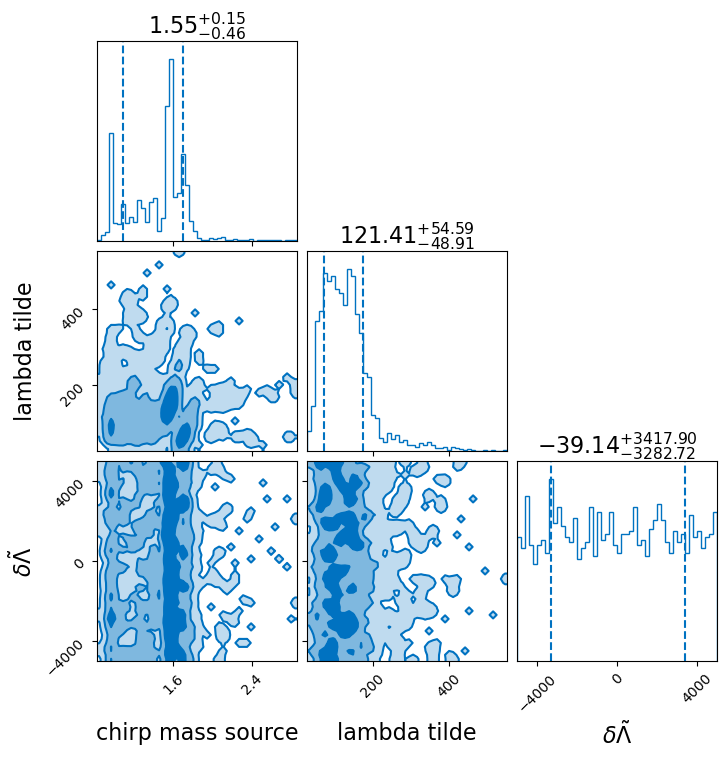

In [57]:
result.plot_corner()